In [23]:
import os
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import matplotlib
matplotlib.rcParams.update({'font.size': 25})

### Set up cluster client

In [2]:
cluster = SLURMCluster()
print(cluster.job_script())
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 00:36:00
#SBATCH --qos=covid-19
#SBATCH --account=covid-19
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:48581 --nthreads 4 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



In [3]:
cluster.scale(5)

In [12]:
client

Client Scheduler: tcp://172.25.220.71:48581 Dashboard: http://172.25.220.71:8787/status,Cluster Workers: 5 Cores: 20 Memory: 100.00 GB


In [24]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42591")
client

Client Scheduler: tcp://127.0.0.1:42591 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


## Demean Temperature and calculate anomaly

In [12]:
t2m = xr.open_dataset('/project2/geos39650/jet_stream/data/df_lat_20_1D.nc')
time_days = t2m.groupby('time.dayofyear').mean().compute()
total_demean = t2m.groupby('time.dayofyear') - ttime_days
total_demean.to_netcdf('/project2/geos39650/jet_stream/data/demean_t2m_1980_2020.nc4')

In [57]:
def decades(x):
    d = int(x.year)//10 * 10
    return d

In [75]:
time_range = pd.date_range(t2m.time.values.min(), t2m.time.values.max())

In [76]:
time_range.year // 10 * 10

Int64Index([1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
            ...
            2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010],
           dtype='int64', length=13604)

In [93]:
t2m = xr.open_dataset('/project2/geos39650/jet_stream/data/df_lat_20_1D.nc')
decades = pd.to_datetime(t2m.time.values).year // 10 * 10
t2m = t2m.expand_dims({'decade': decades})

def demean(x):
    
    d_m = x - x.mean()
    
    return d_m

data_decades = t2m.groupby('decade').map(demean)


total_demean = t2m.groupby('time.dayofyear') - time_days
total_demean.to_netcdf('/project2/geos39650/jet_stream/data/demean_t2m_1980_2020.nc4')

In [27]:
total_demean_t2m = xr.open_dataset('/project2/geos39650/jet_stream/data/demean_t2m_1980_2020.nc4')

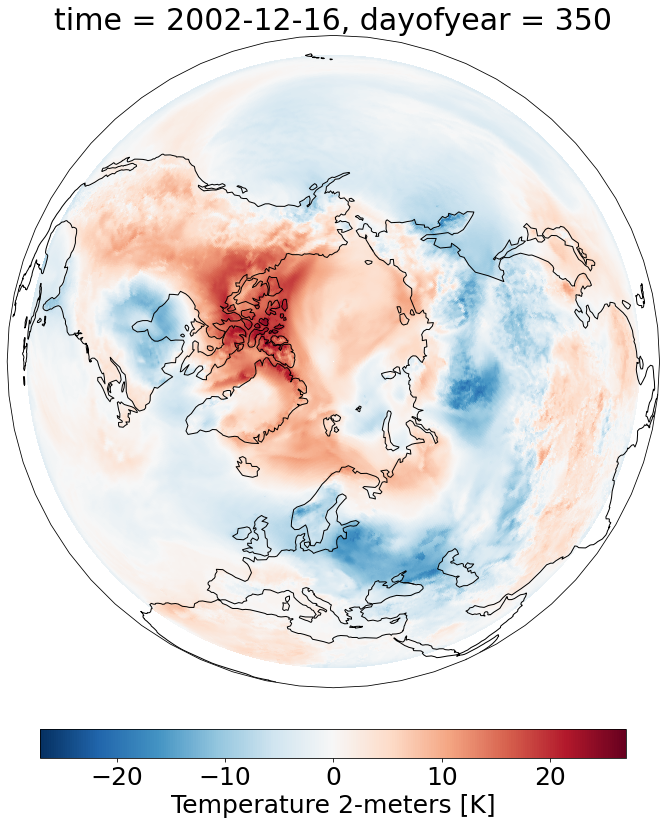

In [30]:
fig = plt.subplots(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Orthographic(20,90))

total_demean.isel(time=2000).t_prime.plot.pcolormesh(ax=ax,
                                      #cmap='Blues_r',
                                      #vmin=240,
                                      #vmax=320,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.7,
                                                  'spacing': 'proportional',
                                                  'label': 'Temperature 2-meters [K]'
                                                 }
                         )
ax.set_global()
ax.coastlines()

In [35]:
def preprocess(ds):
    ds = ds.sortby('time')
    #means_period = ds.mean(dim='time')
    
    return ds 

### Load T-ref files in parallel

In [34]:
paths = list(Path('/project2/geos39650/jet_stream/data/model_output/tprime/').rglob('t_prime_[0-9]*'))
paths

[PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2005-12-01_2010-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2010-12-01_2015-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1995-12-01_2000-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1985-12-01_1990-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2015-12-01_2020-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1980-12-01_1985-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1990-12-01_1995-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2000-12-01_2005-03-01.nc4')]

In [36]:
total = xr.open_mfdataset(paths, 
                          combine='by_coords',
                          preprocess=preprocess)
#total = total.rename({'__xarray_dataarray_variable__': 't_ref'})
total

<xarray.Dataset>
Dimensions:                        (latitude: 280, longitude: 1440, time: 3429)
Coordinates:
  * longitude                      (longitude) float32 0.0 0.25 ... 359.5 359.75
  * latitude                       (latitude) float32 90.0 89.75 ... 20.5 20.25
  * time                           (time) datetime64[ns] 1980-12-01 ... 2018-02-28
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float64 dask.array<chunksize=(451, 280, 1440), meta=np.ndarray>

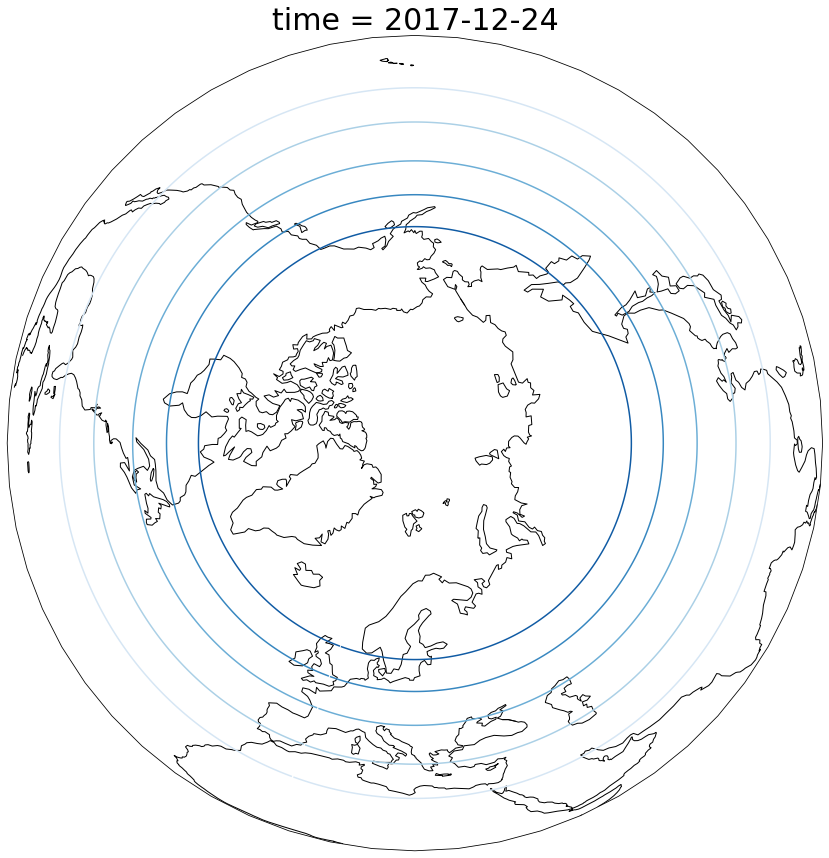

In [22]:
fig = plt.subplots(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Orthographic(20,90))

total.sel(time=datetime(2017, 12, 24)).t_ref.plot.contour(ax=ax,
                                                             cmap='Blues_r',
                                                             #vmin=240,
                                                             #vmax=320,
                                                             transform=ccrs.PlateCarree(),
                                                             extend='neither',
                                                             #cbar_kwargs={'orientation': 'horizontal',
                                                             #              'pad': 0.05,
                                                             #             'shrink': 0.7,
                                                             #             'spacing': 'proportional',
                                                             #             'label': 'Temperature 2-meters [K]'
                                                             #            }
                                                 )
ax.set_global()
ax.coastlines()

In [7]:
df = total.to_dask_dataframe()

In [32]:
df_test = df[(df.time == '2017-12-23') & (df.longitude == 20)].compute()

In [31]:
df_test[df_test.t_ref == 249.408]

,latitude,longitude,time,t_ref
277682,90.00,20.0,2017-12-24,249.408
5215442,89.75,20.0,2017-12-24,249.408
10153202,89.50,20.0,2017-12-24,249.408
15090962,89.25,20.0,2017-12-24,249.408
20028722,89.00,20.0,2017-12-24,249.408
...,...,...,...,...
469364882,66.25,20.0,2017-12-24,249.408
474302642,66.00,20.0,2017-12-24,249.408
479240402,65.75,20.0,2017-12-24,249.408
484178162,65.50,20.0,2017-12-24,249.408


In [ ]:
df.tes

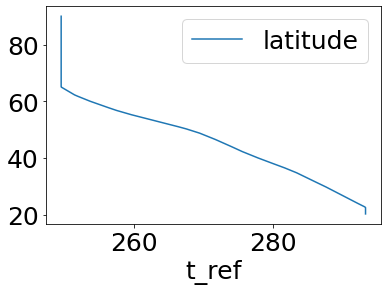

In [17]:
df_test.plot(x='t_ref', y='latitude')

### Load T-prime files in parallel

In [100]:
paths = list(Path('/project2/geos39650/jet_stream/data/model_output/tprime/').rglob('t_prime_[0-9]*'))
paths

[PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2005-12-01_2010-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2010-12-01_2015-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1995-12-01_2000-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1985-12-01_1990-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2015-12-01_2020-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1980-12-01_1985-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_1990-12-01_1995-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_2000-12-01_2005-03-01.nc4')]

In [101]:
total = xr.open_mfdataset(paths, 
                          combine='by_coords',
                          preprocess=preprocess)
total = total.rename({'__xarray_dataarray_variable__': 't_prime'})

In [102]:
total

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 3429)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2018-02-28
Data variables:
    t_prime    (time, latitude, longitude) float64 dask.array<chunksize=(451, 280, 1440), meta=np.ndarray>

### De-mean using the whole period and 10 years

In [37]:
time_days = total.groupby('time.dayofyear').mean().compute()
total_demean = total.groupby('time.dayofyear') - time_days
total_demean.to_netcdf('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020.nc4')

In [127]:
decades = pd.to_datetime(total.time.values).year // 10 * 10
total_decade = total.assign_coords({'decade': decades})

def demean(x):
    
    d_m = x - x.mean()
    
    return d_m

total_demean_decade = total_decade.groupby('decade').map(demean)
#total_demean_decade.to_netcdf('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020_decade.nc4')

In [139]:
total_demean_decade.t_prime[0, :, :, :].to_netcdf('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020_decade.nc4')

In [142]:
total_demean_decade = xr.open_dataarray('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020_decade.nc4')

In [148]:
total_demean_decade

<xarray.DataArray 't_prime' (time: 3429, latitude: 280, longitude: 1440)>
[1382572800 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2018-02-28
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
    decade     int64 1980

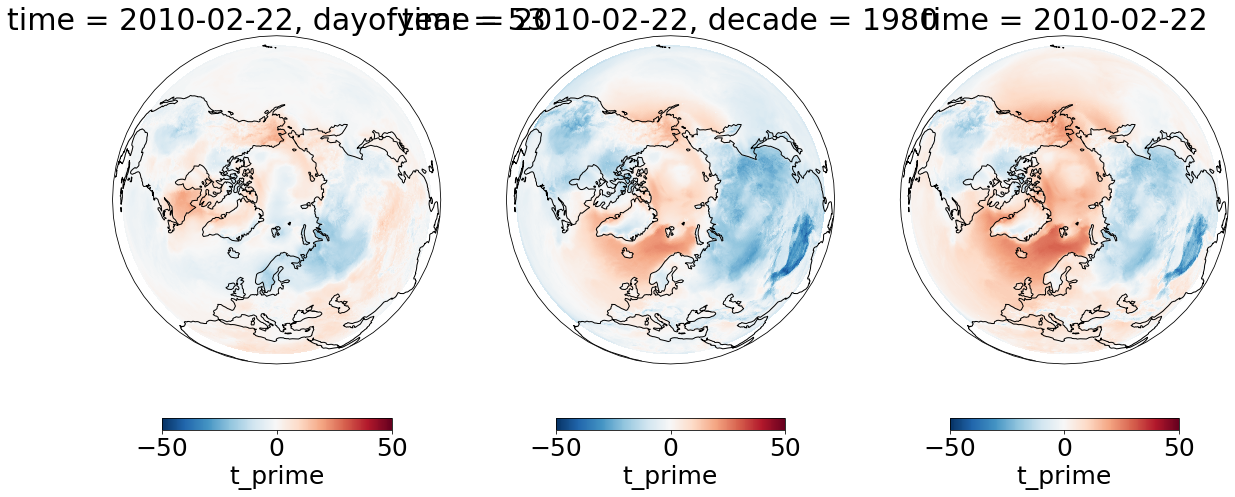

In [151]:
fig_ = plt.figure(figsize=(20, 20))
ax_1 = fig_.add_subplot(131, projection=ccrs.Orthographic(20, 90))
ax_2 = fig_.add_subplot(132, projection=ccrs.Orthographic(20, 90))
ax_3 = fig_.add_subplot(133, projection=ccrs.Orthographic(20, 90))

total_demean.isel(time=2700).t_prime.plot.pcolormesh(ax=ax_1,
                                      cmap='RdBu_r',
                                      vmax=-50,
                                      vmin=50,
                                      center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.7,
                                                  'spacing': 'proportional'
                                                 }
                         )

total_demean_decade.isel(time=2700).plot.pcolormesh(ax=ax_2,
                                      cmap='RdBu_r',
                                      vmax=-50,
                                      vmin=50,
                                      center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.7,
                                                  'spacing': 'proportional'
                                                 }
                         )

total.isel(time=2700).t_prime.plot.pcolormesh(ax=ax_3,
                                      cmap='RdBu_r',
                                      vmax=-50,
                                      vmin=50,
                                      center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.7,
                                                  'spacing': 'proportional'
                                                 }
                         )

ax_1.set_global()
ax_1.coastlines()
ax_2.set_global()
ax_2.coastlines()
ax_3.set_global()
ax_3.coastlines()

In [71]:
diff = total_demean.isel(time=2700).t_prime - total_demean_t2m.isel(time=2700).t2m

In [72]:
diff

<xarray.DataArray (latitude: 280, longitude: 1440)>
array([[ 3.26757314,  3.26757314,  3.26757314, ...,  3.26757314,
         3.26757314,  3.26757314],
       [ 3.26760687,  3.26759121,  3.26761209, ...,  3.2675639 ,
         3.26758559,  3.26759121],
       [ 3.26762855,  3.26762976,  3.26760928, ...,  3.26762052,
         3.26759643,  3.26761731],
       ...,
       [-3.32895436, -3.32896239, -3.32898568, ..., -3.3289656 ,
        -3.32894071, -3.32898729],
       [-3.60092896, -3.60086712, -3.60091531, ..., -3.60087114,
        -3.60091932, -3.60086632],
       [-3.87053253, -3.87051968, -3.87054538, ..., -3.87052771,
        -3.87051888, -3.87055903]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
    time       datetime64[ns] 2010-02-22
    dayofyear  int64 53

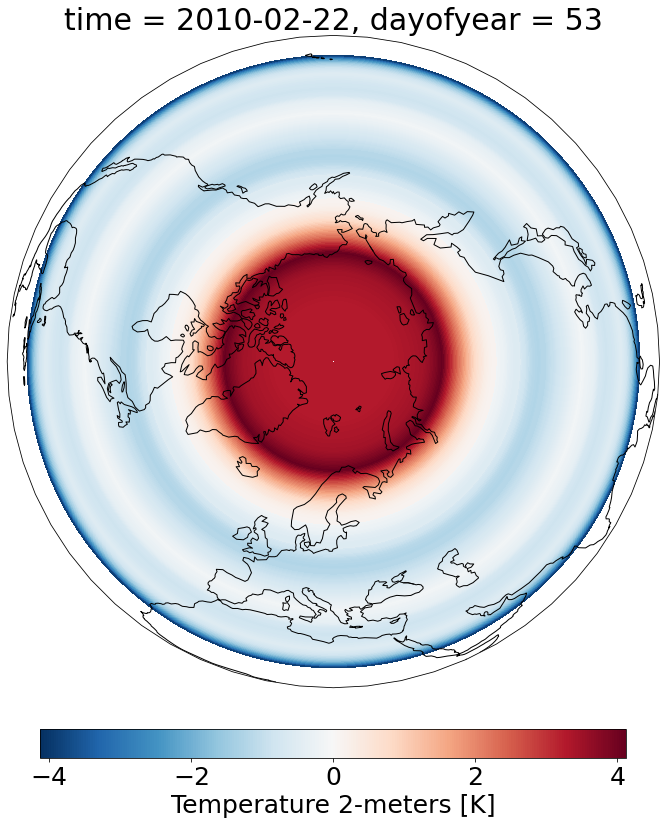

In [73]:
fig = plt.subplots(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Orthographic(20,90))

diff.plot.pcolormesh(ax=ax,
                     #cmap='Blues_r',
                     #vmin=240,
                     #vmax=320,
                     center=0,
                     transform=ccrs.PlateCarree(),
                     extend='neither',
                     cbar_kwargs={'orientation': 'horizontal',
                              'pad': 0.05,
                              'shrink': 0.7,
                              'spacing': 'proportional',
                              'label': 'Temperature 2-meters [K]'
                             }
     )
ax.set_global()
ax.coastlines()

### Loop over years to create a movie

In [ ]:
def plot_avg(data, ax, **kwargs):
    
    # Add layers to axis
    ax.set_global()
    ax.coastlines()
    
    # Plotting function
    data.plot.pcolormesh(ax = ax, 
                         transform=ccrs.PlateCarree(),
                         vmin =params['min'], 
                         vmax=params['max'] ,
                         cmap=params['colormap'], 
                         cbar_kwargs={'orientation': 'horizontal',
                                      'pad': 0.05,
                                      'shrink': 0.5,
                                      'spacing': 'proportional'
                                     }
                        )

In [56]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})


for day in range(2800, 2950):    
    rat = (day - 2800)/(2950-2800) * (150 - 1) + 1
    print(int(np.ceil(rat)))
    
    fig = plt.subplots(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    t2m.isel(time=day).t2m.plot.pcolormesh(ax=ax,
                                          cmap='Blues', 
                                          vmin=240,
                                          vmax=320,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.7,
                                                      'label': "Temperature 2-meters [K]",
                                                      'spacing': 'proportional'
                                                     }
                             )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f'{os.getenv("SCRATCH")}/figs/t2m/t2m_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [53]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})


for day in range(2800, 2950):    
    rat = (day - 2800)/(2950-2800) * (150 - 1) + 1
    print(int(np.ceil(rat)))
    
    fig = plt.subplots(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    total_demean.t_prime.isel(time=day).plot.pcolormesh(ax=ax,
                                          cmap='RdBu_r',
                                          vmax=40,
                                          vmin=-40,
                                          center=0.0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.7,
                                                      'label': "T' [K]",
                                                      'spacing': 'proportional'
                                                     }
                             )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f'{os.getenv("SCRATCH")}/figs/t_prime/t_prime_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

### Loop over year with t2m side by side

In [38]:
top_range = 3400
ceil_range = 3200
for day in range(ceil_range, top_range): 
    rat = (day - ceil_range)/(top_range-ceil_range) * ((top_range-ceil_range) - 1) + 1
    print(int(np.ceil(rat)))


    fig_ = plt.figure(figsize=(20, 20))
    ax_1 = fig_.add_subplot(121, projection=ccrs.Orthographic(20, 90))
    ax_2 = fig_.add_subplot(122, projection=ccrs.Orthographic(20, 90))

    total_demean.isel(time=day).t_prime.plot.pcolormesh(ax=ax_1,
                                          cmap='RdBu_r',
                                          vmax=-50,
                                          vmin=50,
                                          center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )

    t2m.isel(time=day).t2m.plot.pcolormesh(ax=ax_2,
                                          #cmap='RdBu_r',
                                          vmin=240,
                                          vmax=320,
                                          #center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )

    ax_1.set_global()
    ax_1.coastlines()
    ax_2.set_global()
    ax_2.coastlines()

    plt.savefig(f'{os.getenv("SCRATCH")}/figs/t_prime/t2m_t_prime_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

### Solve fucked up T-ref

In [1]:
import dask
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from methods import (calculate_area_from_latitude, 
                     area_calculation_real_area, 
                     dists_of_lat_eff,
                     dask_data_to_xarray,
                     t_prime_calculation)

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42591")
client

Client Scheduler: tcp://127.0.0.1:42591 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


In [3]:
client.upload_file('methods.py')

In [4]:
t2m = xr.open_dataset('/project2/geos39650/jet_stream/data/df_lat_20_1D.nc')
t2m

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 3429)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2018-02-28
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
Data variables:
    t2m        (time, latitude, longitude) float32 ...

In [5]:
#t2m_test = t2m.sel(time=datetime(2015, 12, 1))
#t2m_test
t2m_test = t2m.sel(time=slice('2015-12-01', '2016-12-01'))
t2m_test

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 92)
Coordinates:
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2016-12-01
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
Data variables:
    t2m        (time, latitude, longitude) float32 ...

In [19]:
df_test = t2m_test.to_dask_dataframe(dim_order=['time', 'latitude', 'longitude'])
test_ultimate = t_prime_calculation(df_test,
                                    build_buckets=True,
                                    cut_interval=2
                                   )

In [22]:
test_xarray_tref = dask_data_to_xarray(test_ultimate,
                                  dims=['time', 'latitude', 'longitude'],
                                  target_variable='t_prime')

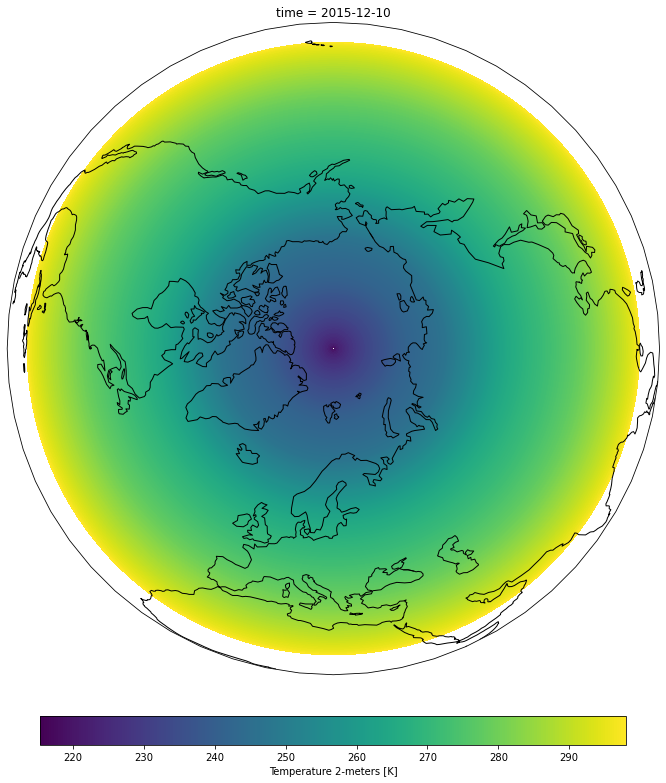

In [21]:
fig = plt.subplots(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Orthographic(20,90))

test_xarray_tref.sel(time=datetime(2015, 12, 10)).plot.pcolormesh(ax=ax,       
                                      #cmap='RdBu_r',
                                      #vmax=-50,
                                      #vmin=50,
                                      #center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.7,
                                                  'spacing': 'proportional',
                                                  'label': 'Temperature 2-meters [K]'
                                                 }
                         )
ax.set_global()
ax.coastlines()

In [9]:
test_ultimate = test_ultimate.compute()

In [21]:
test_ultimate['t_prime'] = test_ultimate['t2m'] - test_ultimate['t_ref']
test_ultimate_idx = test_ultimate.set_index(['time', 'latitude', 'longitude'])

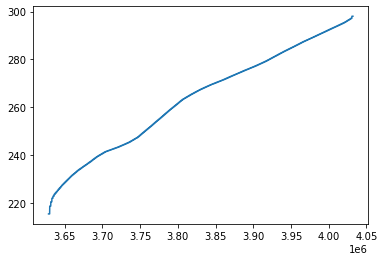

In [22]:
test_ultimate[test_ultimate.time == '2015-12-10'].t_ref.plot()

In [11]:
#test_ultimate = test_ultimate.set_index(['latitude', 'longitude', 'time'])
array_tprime = xr.Dataset.from_dataframe(test_ultimate)

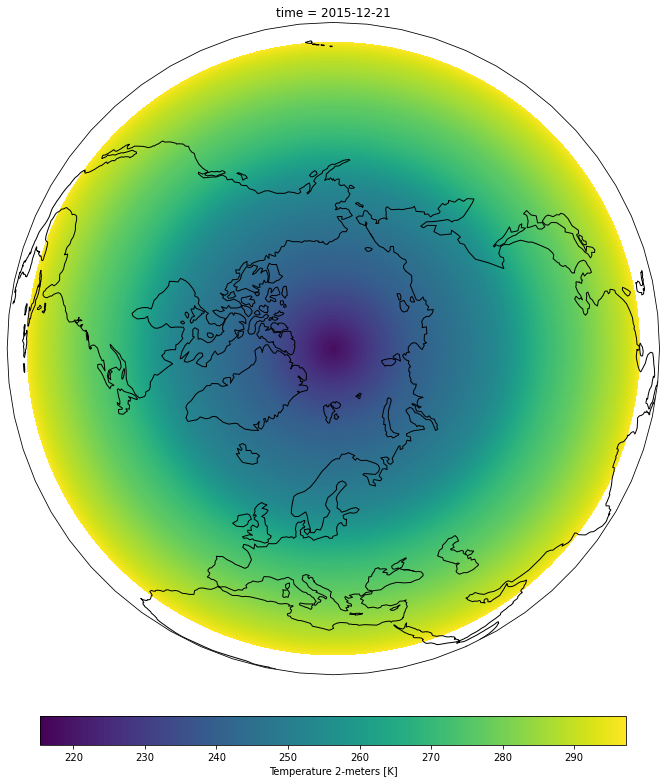

In [12]:
fig = plt.subplots(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Orthographic(20,90))

array_tprime.isel(time=20).t_ref.plot.pcolormesh(ax=ax,       
                                      #cmap='RdBu_r',
                                      #vmax=-50,
                                      #vmin=50,
                                      #center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.7,
                                                  'spacing': 'proportional',
                                                  'label': 'Temperature 2-meters [K]'
                                                 }
                         )
ax.set_global()
ax.coastlines()

In [6]:
df = t2m_test.to_dask_dataframe()
test = area_calculation_real_area(dd_data=df,
                                  cut_interval=2)

In [7]:
areas_test = test.reset_index(drop=False)
areas_test['cdf_eff_lat'] = areas_test.area_grid.apply(lambda x: dists_of_lat_eff(x))
areas_test['cdf_eff_lat_deg'] = np.rad2deg(areas_test.cdf_eff_lat)
areas_test['temp_bracket'] = areas_test.temp_bracket.apply(lambda x: x.left)
areas_test

,temp_bracket,time,area_grid,cdf_eff_lat,cdf_eff_lat_deg
0,215.391,2015-12-01,0.0,1.570796,90.000000
1,215.391,2015-12-02,0.0,1.570796,90.000000
2,215.391,2015-12-03,0.0,1.570796,90.000000
3,215.391,2015-12-04,0.0,1.570796,90.000000
4,215.391,2015-12-05,0.0,1.570796,90.000000
...,...,...,...,...,...
4135,303.391,2016-02-26,167097648.0,0.351249,20.125113
4136,303.391,2016-02-27,167097648.0,0.351249,20.125113
4137,303.391,2016-02-28,167097648.0,0.351249,20.125113
4138,303.391,2016-02-29,167097648.0,0.351249,20.125113


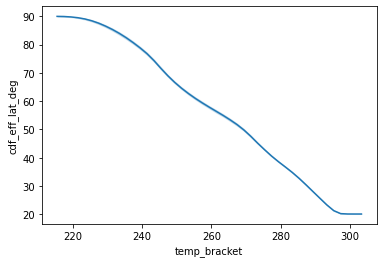

In [9]:
sns.lineplot(data=areas_test,
             x='temp_bracket',
             y='cdf_eff_lat_deg') 

In [35]:
def temp_ref(ddf,
             area_weights,
             temp_binedges,
             cdf_lat_effs):
    """
    Latitudinal reference temperature to capture the gradient effect of the
    jet-stream (t_ref)

   Using the cumulative effective latitude map, temp_ref is the interpolation
   of the effective latitudes given a temperature bucket. An interpolation is
   made per each latitude.

   Parameters:
       - dff (dask.DataFrame): A raw data dask DataFrame
       - area_weights (pd.DataFrame): A data frame with cumulative area mapping
       for each date and bucket. This is the output of
       area_calculation_real_area.
       - temp_binedges (str): column name with the temperature bin. We use
       'temp_brackets'.
       - pdf_lat_effs (str): column name with the name of the cumulative
       effective latitudes.

    Returns: An ndarray with the interpolated values.
    """

    # Filter area_weights
    unique_time = ddf.name
    areas_time = area_weights[area_weights['time'] == unique_time]

    # Interpolate to calculate the t_ref latitde mapping
    t_ref = np.interp(ddf.latitude.unique(),
                      np.flip(areas_time[cdf_lat_effs]),
                      np.flip(areas_time[temp_binedges])
                      )

    t_ref_df = pd.DataFrame({
        't_ref': t_ref,
        'time': unique_time,
        'latitude': ddf.latitude.unique()
    })

    # Merge interpolation data to data dataframe
    #merge_interp = ddf.merge(t_ref_df,
    #                        on=['latitude','time'],
    #                        how='left')

    return t_ref_df


In [36]:
pd.DataFrame([], columns=["t_ref", 'time', 'latitude'], index=pd.Index([], name="time"), dtype=str)

,t_ref,time,latitude
time,,,


In [37]:
df_group = df.groupby('time').apply(temp_ref,
                                    area_weights=areas_test,
                                    temp_binedges='temp_bracket',
                                    cdf_lat_effs='cdf_eff_lat_deg',
                                    meta = pd.DataFrame([], columns=["t_ref", 'time', 'latitude'], index=pd.Index([], name="time"), dtype=str)
                                    )

In [38]:
df_group = df_group.compute()

In [39]:
df_group

t_ref       time  latitude
time                                           
2015-12-01 0    215.391000 2015-12-01     90.00
           1    222.092838 2015-12-01     89.75
           2    222.794676 2015-12-01     89.50
           3    223.508035 2015-12-01     89.25
           4    224.286504 2015-12-01     89.00
...                    ...        ...       ...
2016-12-01 275  296.817630 2016-12-01     21.25
           276  297.032106 2016-12-01     21.00
           277  297.246581 2016-12-01     20.75
           278  297.762917 2016-12-01     20.50
           279  298.901529 2016-12-01     20.25

[25760 rows x 3 columns]

In [15]:
df_group = df_group.reset_index(drop=True)

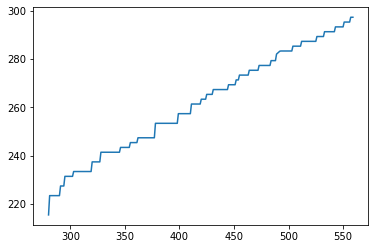

In [18]:
df_group[df_group.time == '2015-12-02'].t_ref.plot()

In [96]:
 temp_ref(ddf=df,
         area_weights=areas_test,
         temp_binedges='temp_bracket',
         cdf_lat_effs='cdf_eff_lat_deg')

In [99]:
t = t.compute()

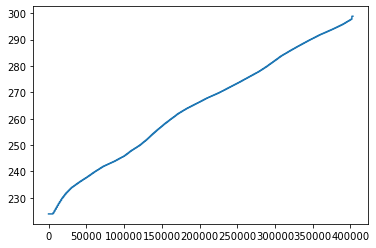

In [100]:
t.t_ref.plot()

In [80]:
t_ref =  np.interp(df.latitude.unique(),
                   np.flip(areas_test['cdf_eff_lat_deg']),
                   np.flip(areas_test['temp_bracket']))

In [81]:
t_ref_df = pd.DataFrame({'t_ref': t_ref,
                        'latitude': df_merge.latitude.unique()}) 
t_ref_df

,t_ref,latitude
0,223.851000,90.00
1,223.851000,89.75
2,223.851000,89.50
3,223.851000,89.25
4,224.268704,89.00
...,...,...
275,296.984967,21.25
276,297.233230,21.00
277,297.481493,20.75
278,297.729756,20.50


In [84]:
merge_test = df.merge(t_ref_df, on=['latitude'], how='left').compute()

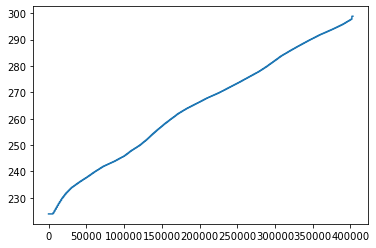

In [85]:
merge_test.t_ref.plot()

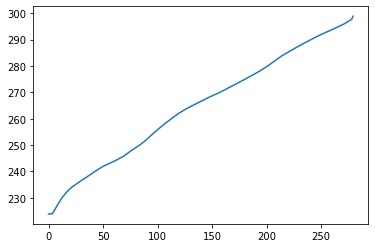

In [87]:
plt.plot(t_ref)